## COVID Group: **Can COVID Case and Death Rates Aid in Predicting the Rise and Fall in Stocks**
### Sam Clark, Mahshad Farnoush, Jagadeesh Meesala, Lily Northcutt, Mengxi Shen
### November 20, 2020
### DATA602

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
# ! pip install pandas_datareader
import pandas_datareader.data as web

from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import classification_report

from sklearn import metrics

import seaborn as sns

# Part 1: Importing COVID Data
## I. Extracting Data
The COVID data we use was gathered from the CDC. The data was taken from January 22, 2020 until November 2, 2020. The data is organized by data, with the following features:
1. Total Cases
2. New Cases
3. Total Death
4. New Deaths

## II. Missing Data and Cleaning
There was no missing data in this dataset (as seen below for covid.info()). However, since we know that we do not have stocks for everyday, we decide to group our data weekly. 

## III. Structure of Dataset
Our COVID dataset looks as follows:
- Each row corresponds to a week
- There are six features in our dataset:
    - Total Cases: a sum over the week
    - New Cases: a sum over the week
    - Total Deaths: a sum over the week
    - New Deaths: a sum over the week
    - Change in Cases
    - Change in Deaths
- There are 42 rows (weeks) that we are considering

In [2]:
## COVID Data
# Downloading Data
rawCovid = pd.read_csv("covid.csv")
variables = ["submission_date", "tot_cases", "new_case", "tot_death", "new_death"]
covid = rawCovid.loc[:,variables]
covid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   submission_date  1000 non-null   object 
 1   tot_cases        1000 non-null   int64  
 2   new_case         1000 non-null   float64
 3   tot_death        1000 non-null   int64  
 4   new_death        1000 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB


In [3]:
# Sum of Week and Adding the difference features
covid["submission_date"] = pd.to_datetime(covid["submission_date"])
covid.rename(columns={"submission_date":"Date"}, inplace=True)

weeklyCovid = covid.groupby(pd.Grouper(key = "Date", freq ="W")).sum()
weeklyCovid.reset_index(inplace=True)

weeklyCovid["case_change"] = weeklyCovid["tot_cases"].diff().fillna(0)
weeklyCovid["death_change"] = weeklyCovid["tot_death"].diff().fillna(0)
weeklyCovid["death_change"].fillna(0, inplace=True)

weeklyCovid.head()

weeklyCovid.to_csv("weeklyCovid.csv")

# Part 2: Stock Data
## I. Choosing our Stocks
We are considering stocks from 9 different industries:
- Bio
- Pharm
- Tech
- Energy
- Retail
- Consumer
- Utility
- Real Estate
- Healthcare

To inform our decision on which stocks we chose to use for each industry, we used a correlation table/heat map to choose between 3-5 stocks. We want to choose uncorrelated stocks so that we capture the behavior of the market, while using less stocks. Additionally, this may help with fitting our model because if we have many highly correlated stocks, the model may only focus in on this and disproportionately favor these stock outcomes.

After we chose the stocks for each industry, we present a correlation table showing relationships between stock behavior across industries.

In [4]:
# Stock Data
# List of our Stocks
bioStock = ["FBRX", "TRIL", "CODX", "ALIM", "BTAI"]
pharmStock = ["ABT", "RCUS", "LLY", "ELAN", "MRK"]
techStocks = ["BILI", "CCOI", "CHT"]
energyStocks = ["CVX","XOM","KMI","WMB","LNG"]
retailStocks = ["WMT","AMZN","COST","BIG","ACI"]
consumerStaplesStocks= ['VDC', 'VCSAX']
utilityStocks= [ 'VUIAX', 'VPU']
realEstateStocks = ['AMT', 'PLD', 'EQIX', 'BAM', 'ZG']
healthCareStocks = ['JNJ', 'MDT', 'NVS', 'PFE', 'GSK']

tickerSymbol = bioStock + pharmStock + techStocks + energyStocks + retailStocks + consumerStaplesStocks + utilityStocks + realEstateStocks + healthCareStocks

In [5]:
start = "2020-01-22"
end = dt.now()

stocks = pd.DataFrame()
sc_df = pd.DataFrame()

for i in tickerSymbol:
    df = web.DataReader(i, "yahoo", start, end)
    df.reset_index(inplace=True)

    weeklyPrice = df.groupby([pd.Grouper(key="Date", freq="W")]).mean()
    weeklyPrice["Stock"] = i
    weeklyPrice.reset_index(inplace=True)
    
    stocks = stocks.append(weeklyPrice[["Adj Close", "Date", "Stock"]],
                          ignore_index = True)
    stocks["stock_price_change"] = stocks["Adj Close"].diff().fillna(0)
    
    sc_df = pd.merge(stocks, weeklyCovid, on="Date")

In [6]:
sc_df.head()

,Adj Close,Date,Stock,stock_price_change,tot_cases,new_case,tot_death,new_death,case_change,death_change
0,8.660000,2020-01-26,FBRX,0.000000,1,1.0,0,0.0,0.0,0.0
1,3.996667,2020-01-26,TRIL,-30.669334,1,1.0,0,0.0,0.0,0.0
2,1.680000,2020-01-26,CODX,-12.238000,1,1.0,0,0.0,0.0,0.0
3,7.433333,2020-01-26,ALIM,-6.278666,1,1.0,0,0.0,0.0,0.0
4,17.196667,2020-01-26,BTAI,12.850667,1,1.0,0,0.0,0.0,0.0


In [7]:
sc_df["Category"] = ""
sc_df.loc[sc_df["Stock"].isin(bioStock), "Category"] = "biotech"
sc_df.loc[sc_df["Stock"].isin(pharmStock), "Category"] = "pharmacy"
sc_df.loc[sc_df["Stock"].isin(techStocks), "Category"] = "it"
sc_df.loc[sc_df["Stock"].isin(energyStocks), "Category"] = "energy"
sc_df.loc[sc_df["Stock"].isin(retailStocks), "Category"] = "retail"
sc_df.loc[sc_df["Stock"].isin(consumerStaplesStocks), "Category"] = "consumer"
sc_df.loc[sc_df["Stock"].isin(utilityStocks), "Category"] = "utility"
sc_df.loc[sc_df["Stock"].isin(realEstateStocks), "Category"] = "realEstate"
sc_df.loc[sc_df["Stock"].isin(healthCareStocks), "Category"] = "healthCare"

In [8]:

sc_df["Rise/Fall"] = ""
sc_df.loc[sc_df["stock_price_change"]>0, "Rise/Fall"] = "1"
sc_df.loc[sc_df["stock_price_change"]<0, "Rise/Fall"] = "-1"
sc_df.loc[sc_df["stock_price_change"]==0, "Rise/Fall"] = np.nan

sc_df.dropna(inplace=True)

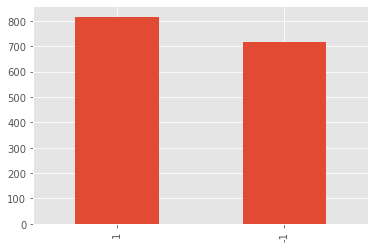

In [9]:
#Chart of Rise/fall
ax = sc_df["Rise/Fall"].value_counts().plot(kind = "bar")

In [10]:
## KNN 
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
sc_df["Category_Enc"] = lb_make.fit_transform(sc_df["Category"])

X = sc_df.drop(columns=['Adj Close','Date','Stock','stock_price_change','Rise/Fall'],axis=1).values
y = sc_df['Rise/Fall'].values

#Splitting into test and train
X_train,X_test,y_train,y_test = tts(X,y,test_size=0.2,random_state=42, stratify=y)


#Arrays to store data accuracy
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# Fitting the model with k=4
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
    
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test) 

#Accuracy:
print("The accuracy score for KNN is:",test_accuracy)

ValueError: could not convert string to float: 'retail'

In [ ]:
#Confusion Matrix
y_pred = knn.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
## Random Forest Classifier

rfc = RandomForestClassifier()

features=["tot_cases", "case_change", "tot_death", "death_change"]

X = sc_df.loc[:, features]
Y = sc_df["Rise/Fall"]
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size=0.2, random_state=42)

rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)

In [ ]:
accuracy = metrics.accuracy_score(Y_test, Y_pred)
print("The accuracy score for random forest classifier is:", accuracy)

In [ ]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
print(classification_report(Y_test,Y_pred))

In [ ]:
# pairwise correlation of columns
covid_stocks_dummies = pd.concat([sc_df, pd.get_dummies(sc_df["Category"], prefix="Dummy")], axis = 1)
covid_stocks_dummies.corr()

In [ ]:

finalVars = ["Rise/Fall","stock_price_change",
             "death_change","case_change",
             "Dummy_biotech", "Dummy_consumer",
             "Dummy_energy", "Dummy_it","Dummy_pharmacy",
             "Dummy_retail", "Dummy_utility"]
final = covid_stocks_dummies.loc[:,finalVars]
final.corr()

In [ ]:
sns.pairplot(final, hue = "Rise/Fall", diag_kind = "kde", plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})